In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.inspection import permutation_importance

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_rows = 99

### Read data

In [4]:
dataset = pd.read_csv('dataset_with_features.csv')

### Analyse data

Before machine learning, I want to evaluate if customers with the same email address (johnlowery@gmail.com) and the same billing address should be kept in one set (train or test) or not. If the data is the same or very similar then I will keep them, if not we can proceed with random selection.

This step is necessary to avoid the data leakage.

In [5]:
dataset[dataset['customerEmail'] == 'johnlowery@gmail.com'].T

,7,40,45,65,79,133,155,165
fraudulent,True,True,True,True,True,True,True,True
customerEmail,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com,johnlowery@gmail.com
customerPhone,044-642-9860,737-377-9701x577,+16(4)9016414340,04712252182,1-820-539-4726x993,1-143-059-1833,076-099-0630x72770,635.676.0955x524
customerDevice,rjb0adai34izqvys4938,jz66ap43id2y35ivfqa5,cdx178qymd6vy77nm4x3,311kdz4c1210iixltk2j,2in0fh7lep289n8dcbdz,tyijaify2hqadwslejyr,6qy6oa3nqutsyyxzc54c,969zz9zdj8z4gns4sx5p
customerIPAddress,212.144.68.190,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,222.79.159.140,42b3:df19:86fe:abd9:dafe:f6c1:eb76:c72,163.128.139.42,e4c:fb48:8ee2:9819:6ae8:8d3f:3b6a:a788,f259:657f:f329:2fca:c06c:8b57:d6ac:2380,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b
customerBillingAddress,"484 Pamela Pass\nLake Jessicaview, WI 12942-9074","08238 Kyle Squares Suite 893\nMillermouth, IN ...","77711 Pamela Ridge\nNew Kayla, IL 27182","11704 Andrew Villages Apt. 035\nJamesfurt, OR ...","814 Wagner Union\nAshleymouth, HI 35617","518 Wood Mews Apt. 970\nDillonstad, NE 43317-3945","687 Rogers Bridge Suite 780\nValdezburgh, IN 2...","548 Bryant Inlet\nVeronicaside, OK 00522"
username,johnlowery,johnlowery,johnlowery,johnlowery,johnlowery,johnlowery,johnlowery,johnlowery
domain,gmail.com,gmail.com,gmail.com,gmail.com,gmail.com,gmail.com,gmail.com,gmail.com
is_popular_domain,True,True,True,True,True,True,True,True
is_disposal_domain,False,False,False,False,False,False,False,False


In [6]:
dataset[dataset['customerBillingAddress'] == '49680 Brian Squares Apt. 122\nPort Walterburgh, MH 02766-0708'].T

,57,80,90
fraudulent,True,True,True
customerEmail,feliciabrown@gmail.com,warrenedward@arnold.com,brittanydean@hotmail.com
customerPhone,(226)129-2677,201.737.5119x64000,06238721842
customerDevice,z7xkuohhjbtiqs6q9rk9,6py7ewqjkxjw8zjl9eri,yq8xiivmx4prlgx0gofo
customerIPAddress,115.137.171.103,45.203.99.249,3517:8e52:885:8640:a59:f5fd:cb33:b06a
customerBillingAddress,49680 Brian Squares Apt. 122\nPort Walterburgh...,49680 Brian Squares Apt. 122\nPort Walterburgh...,49680 Brian Squares Apt. 122\nPort Walterburgh...
username,feliciabrown,warrenedward,brittanydean
domain,gmail.com,arnold.com,hotmail.com
is_popular_domain,True,False,True
is_disposal_domain,False,False,False


For both cases (email and billing address), the data is different. There's no risk of data leakage, so we can proceed with random split.

## Prep dataset

### Choose columns and replace values/fill nas

In [7]:
y = dataset[['fraudulent']]
X = dataset[['is_popular_domain', 'valid_email', 'has_extention_phone_number', 'is_foreign_number',  'order_count', 'unique_order_locations', 'locations_per_order_ratio',
            'avg_order_amount', 'min_order_amount', 'max_order_amount', 'sum_order_amount', 'fulfilled_order_count', 'pending_order_count', 'failed_order_count',
            'address_mismatch_ratio', 'payment_method_type_unique_count', 'payment_method_provider_unique_count', 'payment_method_issuer_unique_count',
            'paymentMethodRegistrationFailure', 'apple pay', 'bitcoin', 'card', 'paypal', 'American Express', 'Diners Club / Carte Blanche', 'Discover', 'JCB 15 digit',
            'JCB 16 digit', 'Maestro', 'Mastercard', 'VISA 13 digit', 'VISA 16 digit', 'Voyager', 'Bastion Banks', 'Bulwark Trust Corp.', 'Citizens First Banks',
            'Fountain Financial Inc.', 'Grand Credit Corporation', 'Her Majesty Trust', 'His Majesty Bank Corp.', 'Rose Bancshares', 'Solace Banks', 'Vertex Bancorp',
            'other_methods', 'transactions_count', 'failed_transactions_count', 'failed_transactions_ratio']]

In [8]:
y.replace({True: 1, False: 0}, inplace=True)

In [9]:
X.fillna(-1, inplace=True)
X.replace({True: 1, False: 0}, inplace=True)
X.replace(-np.inf, -1, inplace=True)

### Split the data

In [10]:
X_array = X.values
y_array = y.values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.35, random_state=100)

In [12]:
print('y_train:', y_train.sum())
print('y_test:', y_test.sum())

y_train: 34
y_test: 27


## Model building

### Start with simple logistic regression

In [13]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

y_train_scores = lr_model.predict_proba(X_train)[:, 1]
y_test_scores = lr_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
average_precision_test = average_precision_score(y_test, y_test_scores)

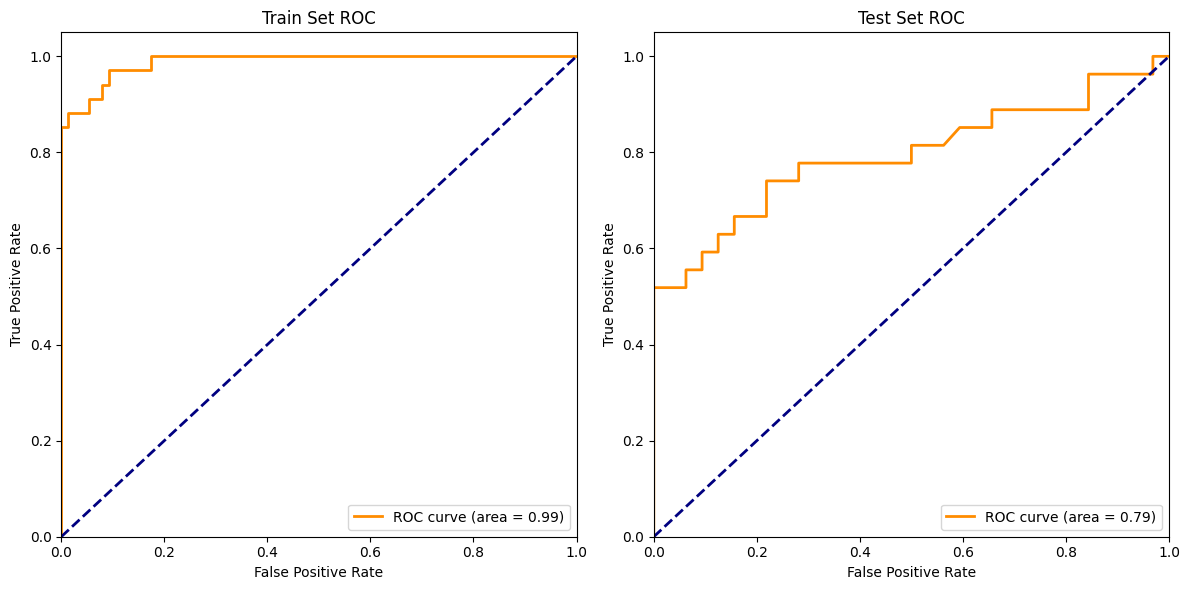

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Set ROC')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

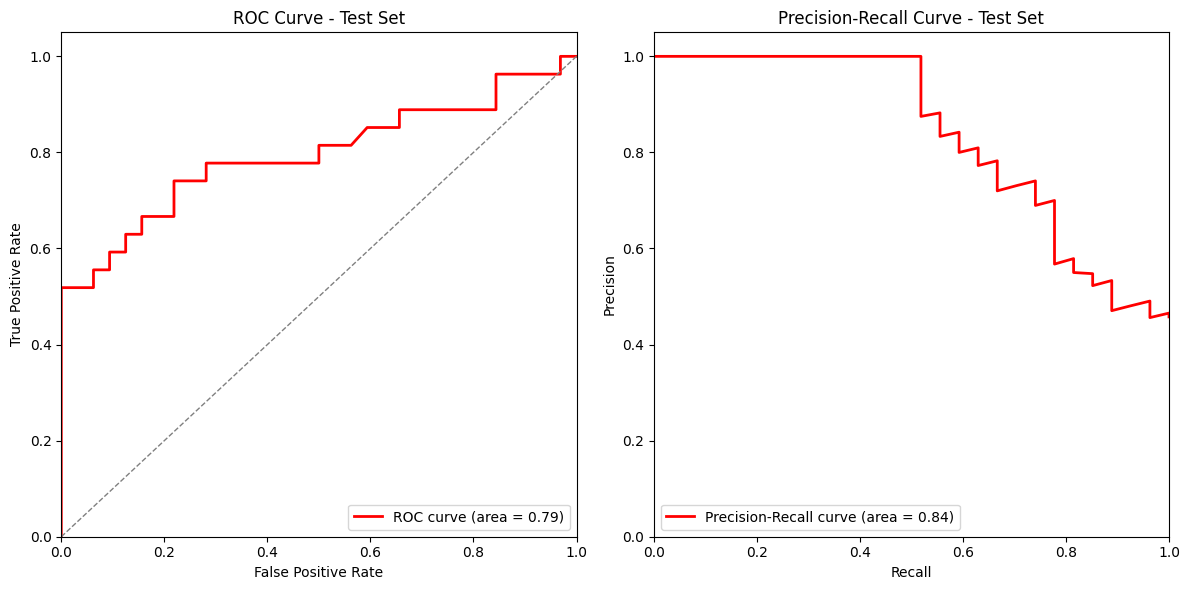

In [15]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

# Plot precision-recall curve for test set
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

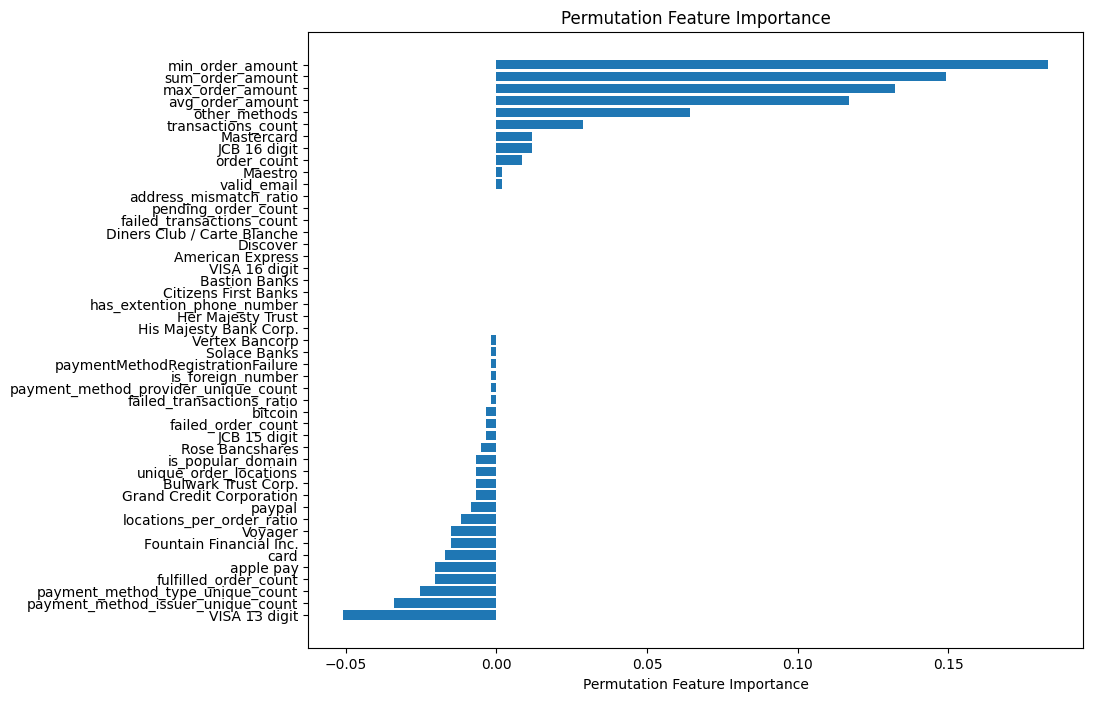

In [16]:
perm_importance_result = permutation_importance(lr_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X.columns

# Plot permutation feature importance
sorted_idx = perm_importance_result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance_result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()

### Build simple Random Forest on all features

Before applying feature selection, I want to run RF Classifier on all features and compare permutation feature importance with the Logistic Regression.

In [17]:
rf_model = RandomForestClassifier(n_estimators=25, min_samples_leaf=2, max_depth=3, random_state=42)
rf_model.fit(X_train, y_train)

y_train_scores = rf_model.predict_proba(X_train)[:, 1]
y_test_scores = rf_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
average_precision_test = average_precision_score(y_test, y_test_scores)

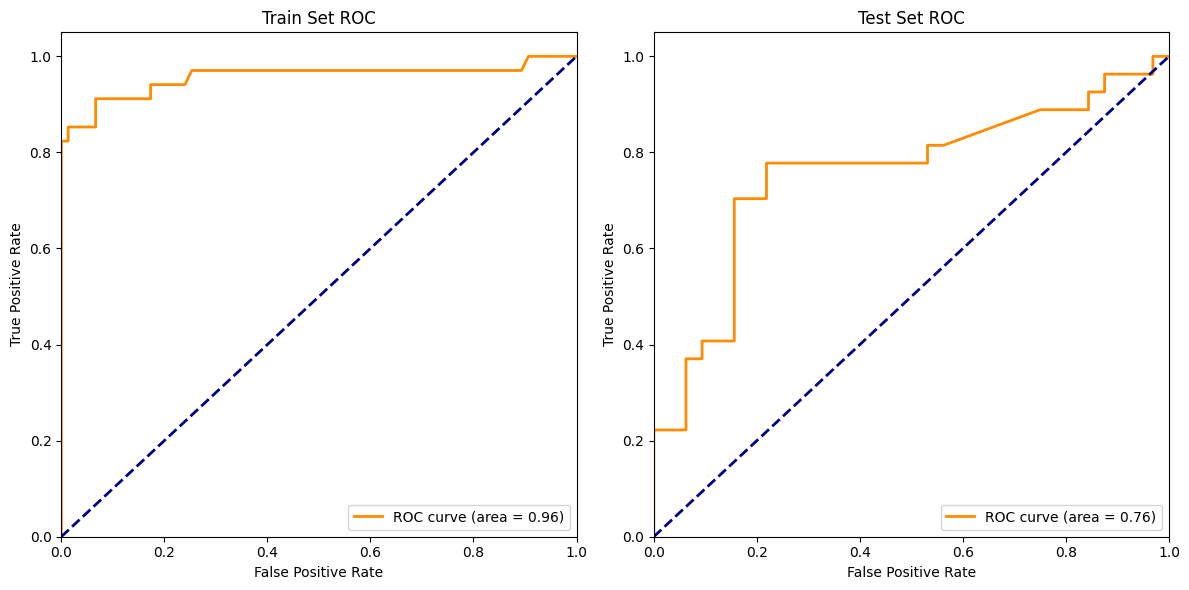

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Set ROC')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

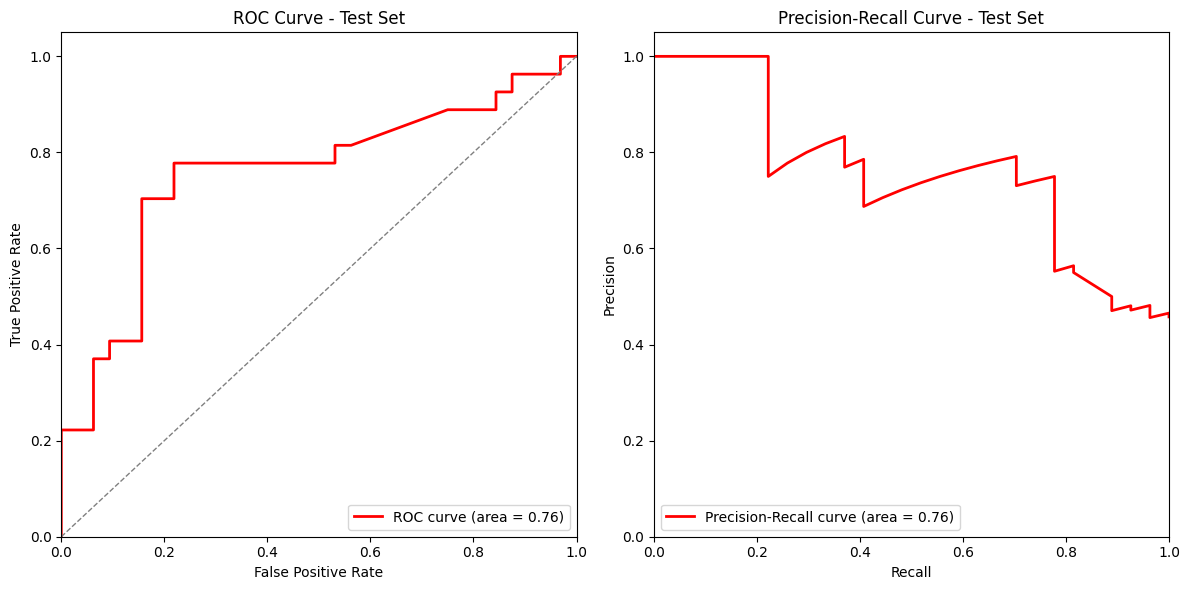

In [19]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

# Plot precision-recall curve for test set
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

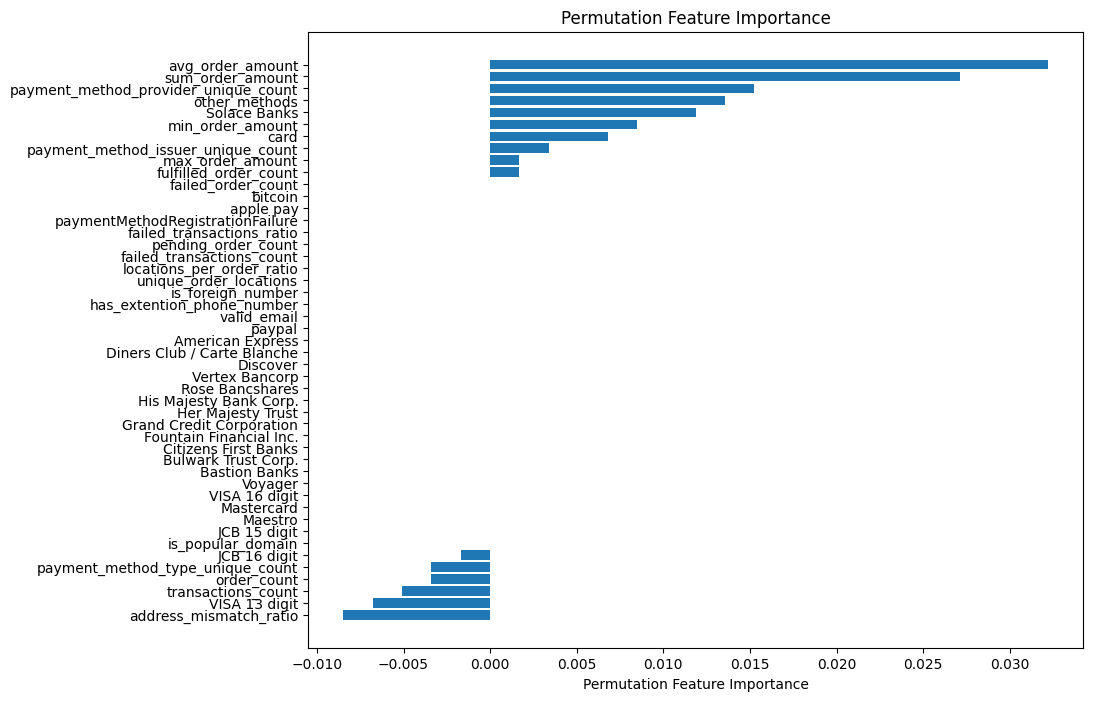

In [20]:
perm_importance_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X.columns

# Plot permutation feature importance
sorted_idx = perm_importance_result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance_result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()

### Feature selection

In [21]:
rfe = RFE(rf_model, n_features_to_select=8)
X_train_selected = rfe.fit_transform(X_train,y_train)

rf_model.fit(X_train_selected,y_train)
X_test_selected = rfe.transform(X_test)

y_train_scores = rf_model.predict_proba(X_train_selected)[:, 1]
y_test_scores = rf_model.predict_proba(X_test_selected)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
average_precision_test = average_precision_score(y_test, y_test_scores)

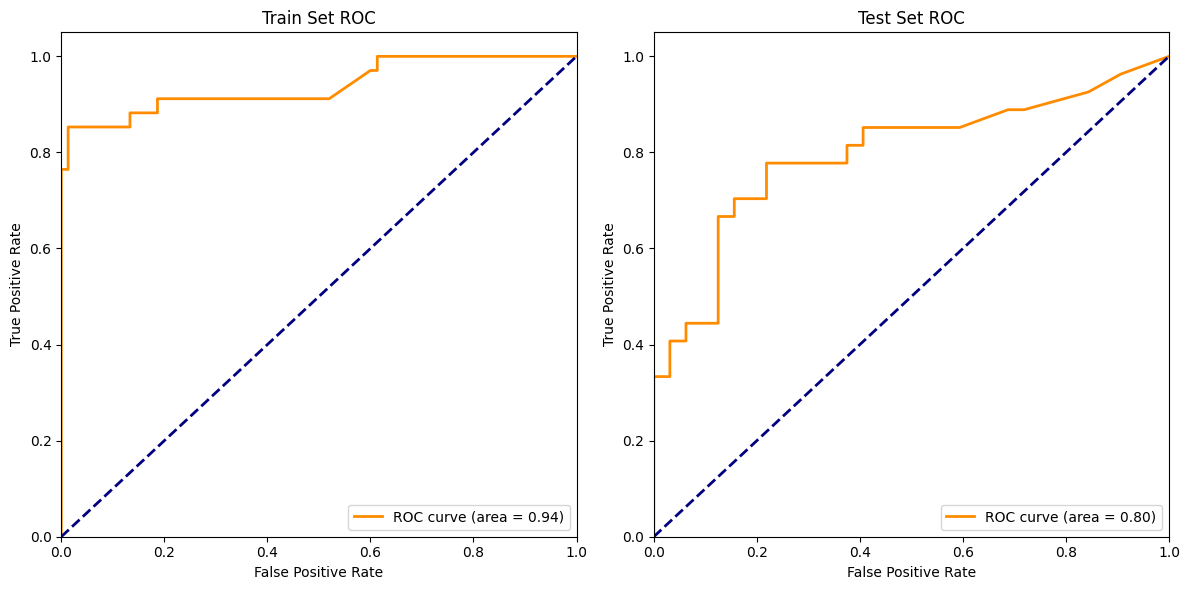

In [22]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_train:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Set ROC')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

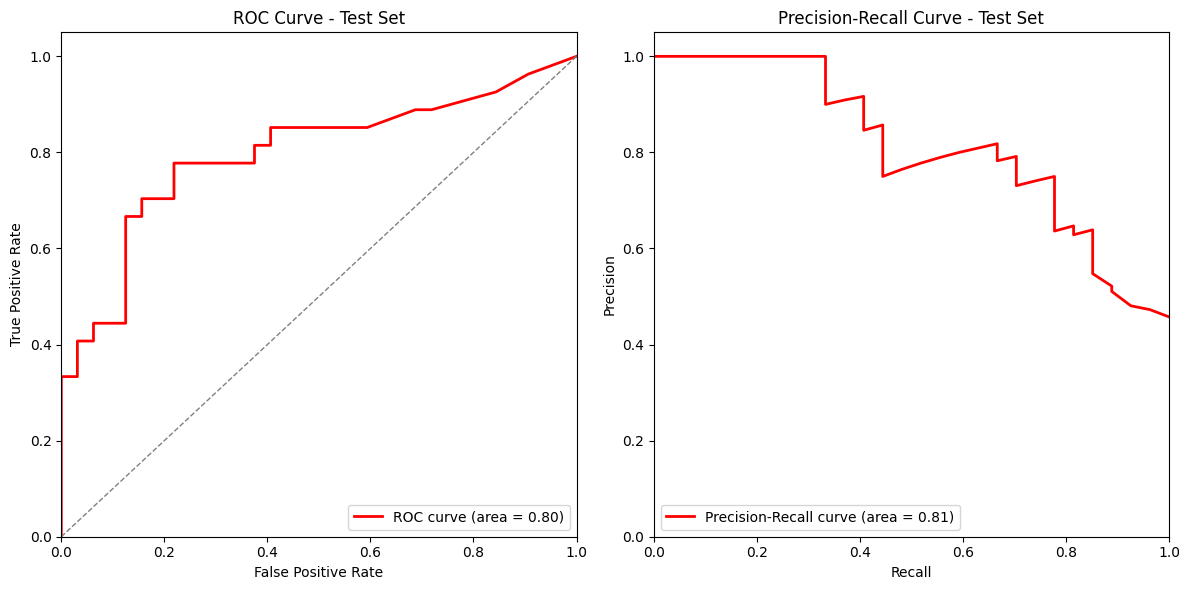

In [23]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

# Plot precision-recall curve for test set
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [24]:
selected_features = rfe.support_
selected_features_indices = [i for i, selected in enumerate(selected_features) if selected]
print("Selected features indices:", selected_features_indices)

Selected features indices: [4, 7, 9, 10, 15, 16, 17, 43]


In [25]:
X.iloc[:,[4, 7, 8, 10, 15, 16, 17, 43]].columns

Index(['order_count', 'avg_order_amount', 'min_order_amount',
       'sum_order_amount', 'payment_method_type_unique_count',
       'payment_method_provider_unique_count',
       'payment_method_issuer_unique_count', 'other_methods'],
      dtype='object')

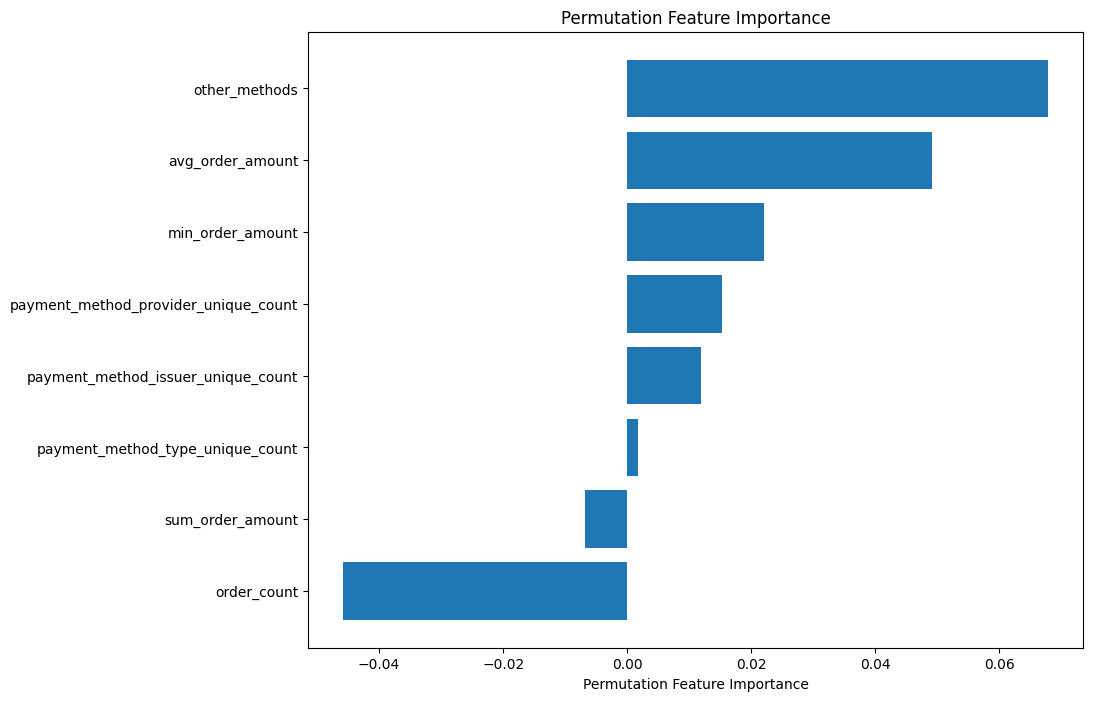

In [26]:
perm_importance_result = permutation_importance(rf_model, X_test_selected, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X.iloc[:,[4, 7, 8, 10, 15, 16, 17, 43]].columns

# Plot permutation feature importance
sorted_idx = perm_importance_result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance_result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()

## Build model with new features using GridSearchCV

In [27]:
# add some user features (email an phone number based) to the one that were selected by feature selection
X_new_array = X.iloc[:,[0, 1, 2, 4, 7, 8, 10, 15, 16, 17, 43]].values
y_new_array = y.values

In [28]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new_array, y_new_array, test_size=0.35, random_state=100)

In [29]:
print('y_train:', y_train.sum())
print('y_test:', y_test.sum())

y_train: 34
y_test: 27


In [33]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 3, 8, 10],
    'max_features': ["sqrt", 2, 5], 
    'min_samples_leaf': [1, 2, 5],
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_new_train, y_new_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = grid_search.best_estimator_
y_pred_val = best_model.predict_proba(X_new_train)[:, 1]
y_pred_test = best_model.predict_proba(X_new_test)[:, 1]

f1_test = f1_score(y_new_test, y_pred_test.round())

fpr_val, tpr_val, _ = roc_curve(y_new_train, y_pred_val)
roc_auc_val = auc(fpr_val, tpr_val)

fpr_test, tpr_test, _ = roc_curve(y_new_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

precision_test, recall_test, _ = precision_recall_curve(y_new_test, y_pred_test)
average_precision_test = average_precision_score(y_new_test, y_pred_test)

print("Best parameters found for F1 score:", best_params)
print("Best F1 score on validation set:", best_score)
print("ROC AUC score on validation set:", roc_auc_val)
print("F1 score on test set:", f1_test)
print("ROC AUC score on test set:", roc_auc_test)

Best parameters found for F1 score: {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 100}
Best F1 score on validation set: 0.8111888111888111
F1 score on validation set: 0.9850746268656716
ROC AUC score on validation set: 0.9984313725490195
F1 score on test set: 0.6818181818181819
ROC AUC score on test set: 0.8206018518518519


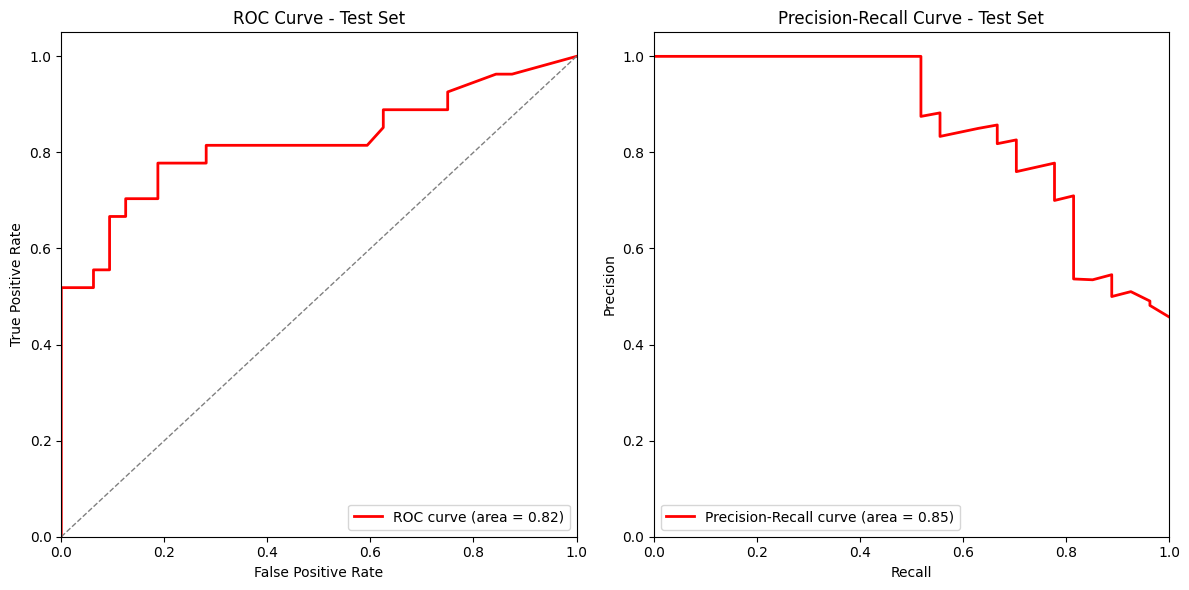

In [34]:
plt.figure(figsize=(12, 6))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

# Plot precision-recall curve for test set
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Test Set')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

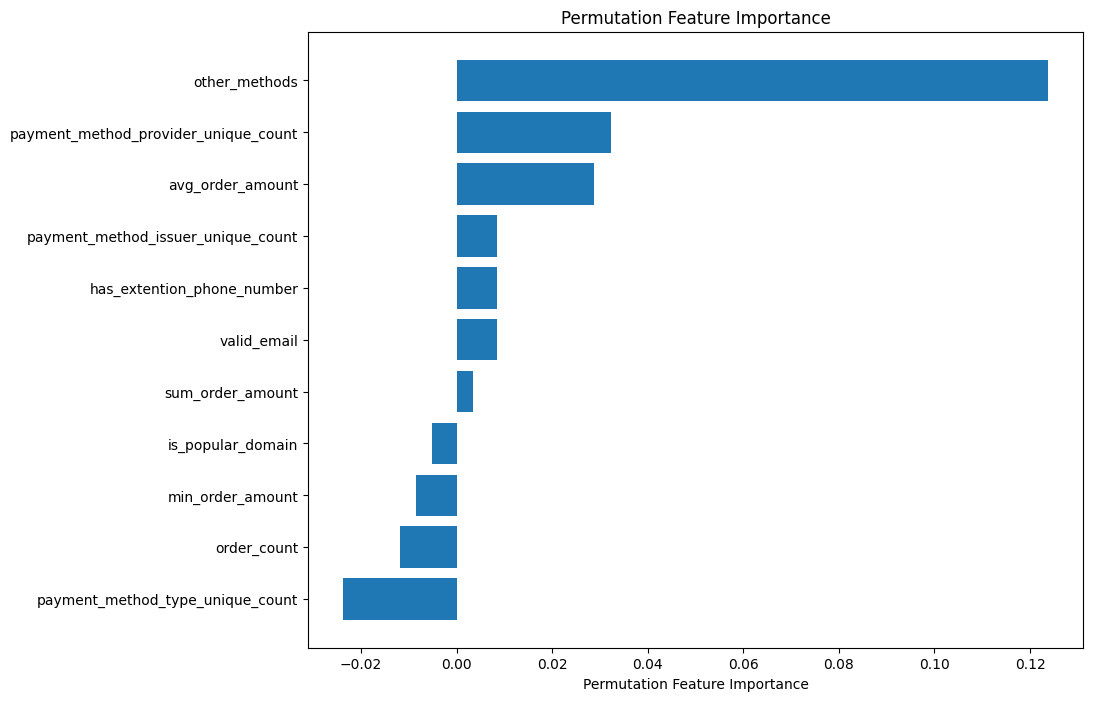

In [35]:
perm_importance_result = permutation_importance(best_model, X_new_test, y_new_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X.iloc[:,[0, 1, 2, 4, 7, 8, 10, 15, 16, 17, 43]].columns

sorted_idx = perm_importance_result.importances_mean.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance_result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Feature Importance')
plt.title('Permutation Feature Importance')
plt.show()

## Conclusions

Generally, the model performs rather well - it reaches 50% recall with 100% precession, but there are a few things to consider. Although the results on the test set for main metrics (ROC score, F1 score) are rather positive and improve with each iteration, there seems to be another problem. Models seem to overfit on the training data. This might be caused by some features, which might be "too" predictive.

To find out which features are the most predictive I used permutation importance. There are two main reasons for choosing that over feature importance. First, permutation importance better shows the importance of each feature individually. Permutation importance measures the impact when one feature is randomly changed when other features are unchanged. Secondly, I calculated it on the test set, so it shows the impact of data that wasn't used to train the model. Feature selection process choose 8 features that were related to
* the number of orders
* prices of orders (min, avg, sum)
* and payment methods:
  * count of unique types, providers, issuers of payment methods 
  * use of "other" issuer methods
  
After running several attempts, I believe the feature "other_methods" might be a problem. As we saw in the EDA, "other_methods" issuers are always associated with fraud. It might be that the model learns to only (or mostly) identify those, rather than focus on other features.
I have manually added "user" features ('valid_email', 'popular_domain', 'has_phone_number_extension') because there are users with no orders/transactions or payment methods. However, they were not predictive. It might be because, as mentioned before, the model fails to learn more difficult patterns and focuses on other features.

Having more time, I would move back to the feature engineering part, and I would try to better understand payment method issuer data. Understanding this data might significantly improve model performance by reducing high variance. Secondly, I would work on user data and try to get more insight from there. It could be IP data or more synergy between shipping and billing addresses (i.e. calculating the distance between two). 

Another thing worth testing is a manual selection of features. It looks like a lot of features chosen in the feature selection process **might** be correlated with each other (4 orders features). A better synergy between user, order, payment methods and transactions might help the model to generalise better. After performing EDA, I was expecting that there would be a greater variety of selected features, but that didn't happen.

It might be worth running more tests on Logistic Regression. The initial results seemed positive. It could be possible to use different algorithms, such as XGBoost, or using hyperparameter optimisation to get better values for the parameters, but there might be not enough data to run those (successfully). 